In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
%matplotlib inline

1. У вас, с прошлого урока, имеются реализации расчёта среднеквадратичной ошибки и её градиента для линейной регрессии с коэффициентами при факторах(w) и свободным коэффициентам.

В этом задании вы должны модифицировать реализацию расчёта среднеквадратичной ошибки и расчёта её производной, так, чтобы с к среднеквадратичной ошибке добавлялась l2 регуляризационная поправка: $ +c*\sum \limits _{j}  w_{j}^2 $ а к градиенту- сответствующее выражение для градиента регуляризационной поправки.

In [2]:
def r2(y, y_real):
    return 1 - np.sum((y_real - y) ** 2) / np.sum((y_real - np.mean(y_real)) ** 2)

In [3]:
class LinearRegression:
    def __init__(self, eta=0.9, max_iter=1e4, min_weight_dist=1e-8,
                 l2_lambda=0):
        self.eta = eta
        self.max_iter = max_iter
        self.min_weight_dist = min_weight_dist
        self.l2_lambda = l2_lambda

    def _mserror(self, X, y_real):
        # рассчёт среднеквадратичной ошибки
        y = X.dot(self.w.T) + self.w0
        _ridge_factor = self.l2_lambda * (np.sum(self.w ** 2) + self.w0 ** 2)
        return np.sum((y - y_real) ** 2) / y_real.shape[0] + _ridge_factor

    def _mserror_grad(self, X, y_real):
        # рассчёт градиента ошибки.
        delta = (X.dot(self.w.T) + self.w0 - y_real)
        _ridge_w = 2 * self.l2_lambda * self.w
        _ridge_w0 = 2 * self.l2_lambda * self.w0
        return 2 * delta.T.dot(X) / y_real.shape[0] + _ridge_w, \
               np.sum(2 * delta) / y_real.shape[0] + _ridge_w0

    def _optimize(self, X, Y):
        # оптимизация коэффициентов
        iter_num = 0
        weight_dist = np.inf
        self.w = np.zeros((1, X.shape[1]))
        self.w0 = 0
        while weight_dist > self.min_weight_dist and iter_num < self.max_iter:
            gr_w, gr_w0 = self._mserror_grad(X, Y)
            if iter_num == 0:
                # Чтобы eta адаптировалась к порядку градиента, делим на l2
                # норму градиента в нуле
                eta = self.eta / np.sqrt(np.linalg.norm(gr_w) ** 2 +
                                         (gr_w0) ** 2)
#                 print(f'Норма {np.linalg.norm(gr_w) ** 2}')
#                 print(f'eta={eta}')
#             print(f'gr_w0:{eta * gr_w0}, gr_w:{eta * gr_w}')
            new_w = self.w - eta * gr_w
            new_w0 = self.w0 - eta * gr_w0
            weight_dist = np.sqrt(np.linalg.norm(new_w - self.w) ** 2 +
                                  (new_w0 - self.w0) ** 2)
            iter_num += 1
            self.w = new_w
            self.w0 = new_w0

    def fit(self, X, Y):
        if Y.ndim == 1:
            Y = Y[:, np.newaxis]
        self._optimize(X, Y)
        return self

    def predict(self, X):
        return (X.dot(self.w.T) + self.w0).flatten()

    def test(self, X, Y):
        if Y.ndim == 1:
            Y = Y[:, np.newaxis]
        return self._mserror(X, Y)

    def weights(self):
        return self.w0, self.w

In [4]:
class PolynomialRegression(LinearRegression):
    def __init__(self, max_power, *args, **kwargs):
        self.max_power=max_power
        super().__init__(*args, **kwargs)
        
    @staticmethod
    def generate_features(x, max_power):
        x=x[:, np.newaxis]
        return np.concatenate([x**i for i in range(1, max_power+1)], axis=1)
    
    def fit(self, x, y):
        super().fit(self.generate_features(x, self.max_power), y)
        
    def predict(self, x):
        return super().predict(self.generate_features(x, self.max_power)).flatten()
    
    def test(self, x, y):
        return super().test(self.generate_features(x, self.max_power), y)

In [5]:
data, target, coef = datasets.make_regression(n_samples=1000, 
                                              n_features = 1, 
                                              n_informative = 2, 
                                              n_targets = 1, 
                                              noise = 20, 
                                              coef = True, 
                                              random_state = 2)

In [6]:
lr_model = LinearRegression()
lr_model.fit(data, target)
lr_model.test(data, target)

370.77302142603895

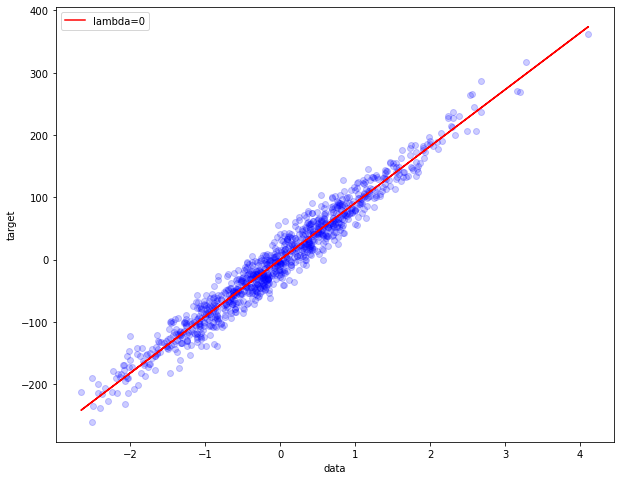

In [7]:
plt.figure(figsize=(10, 8))
plt.xlabel('data')
plt.ylabel('target')
plt.scatter(data, target, color='b', lw=1, alpha=0.2)
plt.plot(data, lr_model.predict(data), color='red', 
         label='lambda=' + str(lr_model.l2_lambda))
plt.legend(loc='best');

In [8]:
r2(lr_model.predict(data), target)

0.9574569510220116

In [9]:
l2_depend = []
lr_model.l2_lambda = 0
for _ in range(100):
    lr_model.fit(data, target)
    l2_depend.append((lr_model.l2_lambda, lr_model.weights()[0], 
                     lr_model.weights()[1][0][0]))
    lr_model.l2_lambda += .01

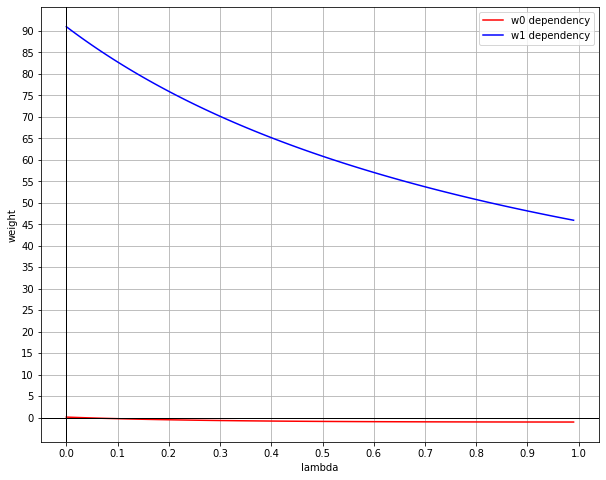

In [10]:
plt.figure(figsize=(10, 8))
plt.plot([_x[0] for _x in l2_depend], [_x[1] for _x in l2_depend], 
         color='red', label='w0 dependency')
plt.plot([_x[0] for _x in l2_depend], [_x[2] for _x in l2_depend], 
         color='blue', label='w1 dependency')
plt.xlabel('lambda')
plt.ylabel('weight')
plt.axhline(lw=1, color='black')
plt.axvline(lw=1, color='black')
plt.yticks(np.arange(0, 91, 5))
plt.xticks(np.arange(0, 1.1, 0.1))
plt.grid()
plt.legend(loc='best');

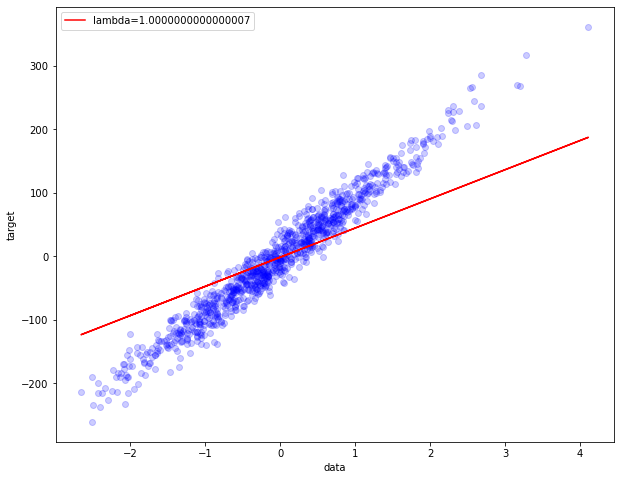

In [11]:
plt.figure(figsize=(10, 8))
plt.xlabel('data')
plt.ylabel('target')
plt.scatter(data, target, color='b', lw=1, alpha=0.2)
plt.plot(data, lr_model.predict(data), color='red', 
         label='lambda=' + str(lr_model.l2_lambda))
plt.legend(loc='best');

In [12]:
r2(lr_model.predict(data), target)

0.7227005171608374

___

2. На основе этих функций создайте свою регуляризированную полиномиальную регрессию и опробуйте на одном из примеров построения полиномиальной модели из этого урока. <br>

<i><b>Пояснение:</b>Для этого Вам достаточно создать класс, который наследуется от класса polynomial_regression из данного урока, и переопределить в нём методы mserror, mserror_grad(под переопределением подразумевается создание на новом классе методов с таким же названием). </i>

Так как я наследуюсь с класса линейной регрессии, в котором уже реализовал l2 регуляризацию, переопределять методы не вижу смысла

In [13]:
def f(x):
    return 0.6 - 13.2 * x - 5.3 * x ** 2 - 4.17 * x ** 3

np.random.seed(16)
dots = np.linspace(-10, 10, 100)
x_number = 30
x_data = np.random.uniform(-10, 10, x_number)
f_data = [f(i) for i in x_data] + np.random.uniform(-2000, 2000, x_number)

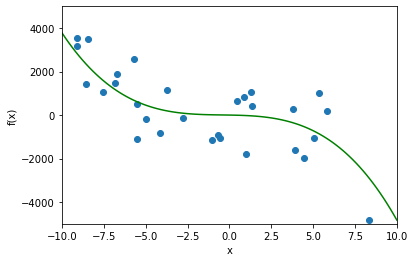

In [14]:
plt.xlabel('x')
plt.ylabel('f(x)')
plt.ylim(-5000, 5000)
plt.xlim(-10,10)

plt.plot(dots, f(dots), color='g')
plt.scatter(x_data, f_data);

In [15]:
pr_model = PolynomialRegression(5, eta=0.005, max_iter=1e4, l2_lambda=0)
pr_model.fit(x_data, f_data)
print(r2(pr_model.predict(x_data), f_data))

0.7357029151328468


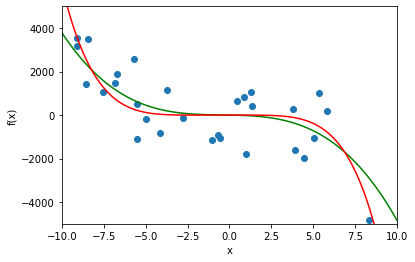

In [16]:
plt.xlabel('x')
plt.ylabel('f(x)')
plt.ylim(-5000, 5000)
plt.xlim(-10,10)

plt.plot(dots, f(dots), color='g')
plt.plot(dots, pr_model.predict(dots), color='red')
plt.scatter(x_data, f_data);

In [17]:
pr_model.weights()

(-8.866347452917453e-05,
 array([[-0.00059642, -0.00097678, -0.01683922, -0.20814431, -0.07976878]]))

3*.(по желанию). Оцените оцените предсказательную способность реализованного метода с использование 5-ти ступенчатой кросс-валидации, показанной в примере выше. 

In [22]:
def cross_valid(model, X, y, n_folds=5):
    indexes=np.arange(len(y)) % n_folds
    y_actual=[]
    y_predicted=[]

    for i in range(n_folds):
        y_actual.append(y[indexes == i])
        model.fit(X[indexes != i], y[indexes != i])
        y_predicted.append(model.predict(X[indexes == i]))

    y_actual = np.concatenate(y_actual)
    y_predicted = np.concatenate(y_predicted)
    return y_predicted, y_actual


y_pred, y_real = cross_valid(PolynomialRegression(3, max_iter=1e4, l2_lambda=0), x_data, f_data)
r2(y_pred, y_real)